In [1]:
import sys
import random
import math
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import glob 

In [2]:
import numpy as np
import pandas as pd
import tensorflow
import cv2
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import imageai
from imageai.Detection.Custom import CustomObjectDetection
from imageai.Detection import ObjectDetection
from keras.models import model_from_json
from keras.models import load_model
from skimage.segmentation import mark_boundaries

Using TensorFlow backend.


In [3]:
'''utility functions for loading and saving pickle files'''
import pickle
def saveInPickle(data, pickleFile):
    file = open(pickleFile,"wb")
    pickle.dump(data,file)
    file.close()
def loadFromPickle(pickleFile):
    file = open(pickleFile,'rb')
    pickleData = pickle.load(file)
    file.close()
    return pickleData

In [28]:
'''loading yolo model'''
yoloModel = CustomObjectDetection()
yoloModel.setModelTypeAsYOLOv3()
yoloModel.setModelPath("yolo_detection_model-ex-001--loss-0026.385.h5")
yoloModel.setJsonPath("yolo_detection_config.json")
yoloModel.loadModel()
print("yolo model loaded")

'''loading unet model'''
json_file = open('unet_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
unetModel = model_from_json(loaded_model_json)
unetModel.load_weights("unet_model.h5")
print("unet model loaded")

'''loading retina-net model'''
retinanet  = ObjectDetection()
retinanet.setModelTypeAsRetinaNet()
retinanet.setModelPath("retinanet-cocoa-data.h5")
retinanet.loadModel()
retinanet_customClasses = retinanet.CustomObjects(boat=True)
print("retinanet model loaded")

print("Loaded model from disk")

yolo model loaded
unet model loaded

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
retinanet model loaded
Loaded model from disk


In [19]:
'''returns bounding box coordinates from mask images'''
def getBBoxFromMask(maskImage):
    labels = label(maskImage) 
    coordinates = regionprops(labels)
    return coordinates

'''returns bbox for UNET'''
def unetBBOX(imagePath):
    image = cv2.imread(imagePath)
    image  = cv2.resize(image, (256,256))
    image = np.expand_dims(image, 0)/255.0
    predictedImage = unetModel.predict(image)[0]
    bbox = getBBoxFromMask(predictedImage[:, :, 0])
#     bbox = getBBoxFromMask(predictedImage)
#     cv2.rectangle(image, (bbox[0]*3, bbox[1]*3), (bbox[2]*3, bbox[3]*3), (255, 0, 0), 2)
    bboxList = []
    for box in bbox:
        bboxList.append([box.bbox[1]*3, box.bbox[0]*3, box.bbox[3]*3, box.bbox[2]*3])
        
    return bboxList  ### return list of bounding boxes

'''returns bbox for YOLO'''
def yoloBBox(imagePath):
    bbox = yoloModel.detectObjectsFromImage(input_image=imagePath, output_image_path="random.jpg", nms_treshold=0.2)
    bboxList = []
    scoreList = []
    for box in bbox:
#         print(box)
        bboxList.append(box["box_points"])
        scoreList.append(box["percentage_probability"])
    
#     print(scoreList)
    return scoreList,bboxList  ### return list of bounding boxes

'''returns bbox for retinaNet'''
def retinaBBox(imagePath):
    bbox = retinanet.detectObjectsFromImage(input_image=imagePath, output_image_path="random.jpg")
    bboxList = []
    scoreList = []
#     print(bbox)
    for box in bbox:
        bboxList.append(box["box_points"])
        scoreList.append(box["percentage_probability"])
        
    return scoreList, bboxList

In [11]:
'''converts mask in image'''
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

'''decodes RLE encoded image'''
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 


In [8]:
'''ground truth for each image'''
annotations = pd.read_csv('train_ship_segmentations_v2.csv')

In [12]:

'''generates list of ground truth bounding boxes for testing image'''

imagesPath = "validation"
gTruth_bbox_dict = {}
for dir,_, files in os.walk(imagesPath):
    print(len(files))
    for i in tqdm(list(range(len(files)))):
        imagePath = imagesPath +"\\"+ files[i]
        image_id = files[i]
        image = cv2.imread(imagePath)
#         image = imread(os.path.join(train_dir, image_id))
            
        rle_img = annotations.query('ImageId=="'+image_id+'"')['EncodedPixels']
        gt_mask = masks_as_image(rle_img)

        gt_lbl = label(gt_mask) 
        props = regionprops(gt_lbl)
        boxes = []
        for prop in props:
            boxes.append(prop.bbox)

        gTruth_bbox_dict[image_id] = boxes

1988


In [24]:
'''These functions are used to get predicted bounding box list for each test image'''

imagesPath = "validation"
def getYoloBBOX():
    predicted_bbox_dict = {}
    predicted_scores = {}
    for dir,_, files in os.walk(imagesPath):
        print(len(files))
        for i in tqdm(list(range(len(files)))):
            imagePath = imagesPath +"\\"+ files[i]
    #         print(imagePath)
            try:
                scoreList,bboxList = yoloBBox(imagePath)
        #         unetBboxList = unetBBOX(imagePath)
                predicted_bbox_dict[files[i]] = bboxList
                predicted_scores[files[i]] = scoreList
            except:
                continue
            ## use these boundign boxes as per your need

    return predicted_bbox_dict, predicted_scores

def getUnetBBOX():
    predicted_bbox_dict = {}
    for dir,_, files in os.walk(imagesPath):
        print(len(files))
        for i in tqdm(list(range(len(files)))):
            imagePath = imagesPath +"\\"+ files[i]
    #         print(imagePath)
    #         yoloBboxList = yoloBBox(imagePath)
            unetBboxList = unetBBOX(imagePath)
            predicted_bbox_dict[files[i]] = unetBboxList
            
    return predicted_bbox_dict

def getRetinaBBOX():
    retina_predicted_bbox_dict = {}
    retina_predicted_scores = {}
    for dir,_, files in os.walk(imagesPath):
#         print(len(files))
        for i in tqdm(list(range(len(files)))):
            imagePath = imagesPath +"\\"+ files[i]
            scoreList,bboxList = retinaBBox(imagePath)
            retina_predicted_bbox_dict[files[i]] = bboxList
            retina_predicted_scores[files[i]] = scoreList
                
    return retina_predicted_bbox_dict, retina_predicted_scores


In [29]:
retina_predicted_bbox_dict, retina_predicted_scores = getRetinaBBOX()

In [14]:
unet_predicted_bbox_dict = getUnetBBOX()
yolo_predicted_bbox_dict, yolo_predicted_scores = getYoloBBOX()


1988




1988


In [116]:
mrcnn_predicted_bbox_dict = loadFromPickle('pickle_Mrcnn_predicted_bbox_dict')
mrcnn_predicted_scores = loadFromPickle('pickle_Mrcnn_predicted_scores')

In [17]:
'''saving the predicted bbox results for future use'''

saveInPickle(gTruth_bbox_dict,'pickle_gTruth_bbox_dict')
saveInPickle(unet_predicted_bbox_dict, 'pickle_unet_predicted_bbox_dict')
saveInPickle(yolo_predicted_bbox_dict, 'pickle_yolo_predicted_bbox_dict')
saveInPickle(yolo_predicted_scores, 'pickle_yolo_predicted_scores')

In [30]:
saveInPickle(retina_predicted_bbox_dict, 'pickle_retina_predicted_bbox_dict')
saveInPickle(retina_predicted_scores, 'pickle_retina_predicted_scores')

In [117]:
print(len(gTruth_bbox_dict))
print(len(unet_predicted_bbox_dict))
print(len(yolo_predicted_bbox_dict))
print(len(retina_predicted_bbox_dict))
print(len(mrcnn_predicted_bbox_dict))
image_list = list(yolo_predicted_bbox_dict.keys())

1988
1988
1977
1988
1988


In [54]:
'''utility function to calculate iou for each predicted bounding box'''
def getClosestBoxIOU(boxes_p,box_g):
    maxIOU = 0
    for box_p in boxes_p:
        max0 = max(box_g[0], box_p[0])
        max1 = max(box_g[1], box_p[1])
        min2 = min(box_g[2], box_p[2])
        min3 = min(box_g[3], box_p[3])
        
        intersectionArea = max(0, min2 - max0 + 1) * max(0, min3 - max1 + 1)
        box_g_Area = (box_g[2] - box_g[0] + 1) * (box_g[3] - box_g[1] + 1)
        box_p_Area = (box_p[2] - box_p[0] + 1) * (box_p[3] - box_p[1] + 1)
        
        iou = intersectionArea / float(box_g_Area + box_p_Area - intersectionArea)
        maxIOU = max(maxIOU, iou)
    return maxIOU

'''calculates Intersection Over Union for predicted bounding box.'''
def intersectionOverUnion(predicted_bbox_dict, gTruth_bbox_dict):
    
    iou_dict = {}
    for image_id in tqdm(image_list):
        iou_dict[image_id] = []
        
        boxes_g = gTruth_bbox_dict[image_id]
        boxes_p = predicted_bbox_dict[image_id]
#         if len(boxes_g) > 1:
#             print("image_id :",image_id)
#             print("boxes_g :",boxes_g)
#             print("boxes_p :",boxes_p)
            
        if len(boxes_g) == 0 and len(boxes_p) == 0:
            iou_dict[image_id].append(1)
        elif len(boxes_g) == 0:
            iou_dict[image_id].append(0)
        elif len(boxes_p) == 0:
            for i in range(len(boxes_g)):
                iou_dict[image_id].append(0)
        
            
        else:
            for gt_box in boxes_g:
                iou_dict[image_id].append(getClosestBoxIOU(boxes_p,gt_box))
                
    return iou_dict


In [55]:
unet_iou_dict = intersectionOverUnion(unet_predicted_bbox_dict, gTruth_bbox_dict)
yolo_iou_dict = intersectionOverUnion(yolo_predicted_bbox_dict, gTruth_bbox_dict)
retina_iou_dict = intersectionOverUnion(retina_predicted_bbox_dict, gTruth_bbox_dict)
# print(len(iou_dict))

100%|██████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 283220.81it/s]


In [118]:
mrcnn_iou_dict = intersectionOverUnion(mrcnn_predicted_bbox_dict, gTruth_bbox_dict)

100%|████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 6869.12it/s]


In [120]:
Gt_bboxes_count = 0
unet_bboxes_count = 0
yolo_bboxes_count = 0
retina_bboxes_count = 0
mrcnn_bboxes_count = 0
for image_id in gTruth_bbox_dict.keys():
    Gt_bboxes_count += len(gTruth_bbox_dict[image_id])
for image_id in unet_iou_dict.keys():
    unet_bboxes_count += len(unet_iou_dict[image_id])
for image_id in yolo_iou_dict.keys():
    yolo_bboxes_count += len(yolo_iou_dict[image_id])
for image_id in retina_iou_dict.keys():
    retina_bboxes_count += len(retina_iou_dict[image_id])
for image_id in mrcnn_iou_dict.keys():
    mrcnn_bboxes_count += len(mrcnn_iou_dict[image_id])
    
print(Gt_bboxes_count)
print(unet_bboxes_count)
print(yolo_bboxes_count)
print(retina_bboxes_count)
print(mrcnn_bboxes_count)

5232
5201
5201
5201
5201


In [122]:
'''this function generates precision, recall for each test images and saves them in a list '''
def evaluate(iou_dict):
    precision_list = []
    recall_list = []
    iou_list = []
    tp_acc = 0
    fp_acc = 0


    scoreTpFp_df = pd.DataFrame(columns=['imageId', 'TP', 'FP'])
    for img_id in tqdm(iou_dict.keys()):
    #     if len(predicted_scores[img_id]) > 0:
        for i in range(len(iou_dict[img_id])):
            tp, fp = 0, 0
    #         score = predicted_scores[img_id][i]
            if iou_dict[img_id][i] >= 0.50:
                tp=1
            else:
                fp=1

            iou_list.append(iou_dict[img_id][i])
            arr = pd.Series([img_id, tp, fp], index = scoreTpFp_df.columns)
            scoreTpFp_df = scoreTpFp_df.append(arr, ignore_index=True)

    # scoreTpFp_df.sort_values('score', axis = 0, ascending = False,inplace = True) 
    # print(scoreTpFp_df.shape)

    Precision_Recall_df = pd.DataFrame(columns=['imageId', 'TP', 'FP','TP_Acc','FP_Acc','Precision','Recall'])
    for index, row in tqdm(scoreTpFp_df.iterrows(), total=scoreTpFp_df.shape[0]):
    #     print(row['c1'], row['c2'])
        img_id = row['imageId']
    #     score = row['score']
        tp = row['TP']
        fp = row['FP']
        if tp==1:
            tp_acc += 1
        if fp==1:
            fp_acc += 1
        precision = tp_acc / (tp_acc+fp_acc)
        recall = tp_acc / Gt_bboxes_count
        precision_list.append(precision)
        recall_list.append(recall)
        arr = pd.Series([img_id, tp, fp, tp_acc, fp_acc, precision, recall], index = Precision_Recall_df.columns)
        Precision_Recall_df = Precision_Recall_df.append(arr, ignore_index=True)
        
    return Precision_Recall_df, iou_list

In [128]:
'''plots comparison graph for retina, yolo, unet'''
def scatter_plot(g1y,g1x,g2y,g2x,g3y,g3x,g4y,g4x,xlabel,ylabel,title):
    plt.plot(g3x,g3y ,label='retina', marker='.',linewidth=.5, color = 'blue')
    plt.plot(g2x,g2y ,label='yolo', marker='.',linewidth=.5, color = 'green')
    plt.plot(g1x,g1y ,label='unet', marker='.',linewidth=.5, color = 'red')
#     plt.plot(g4x,g4y ,label='mrcnn', marker='.',linewidth=.5, color = 'yellow')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [124]:
'''this function generates final precision, recall, f1Score for each model and generates relevant graphs '''
def eval_metrics(unet_df, yolo_df, retina_df, mrcnn_df, unet_iou_list, yolo_iou_list, retina_iou_list, mrcnn_iou_list):
    eval_dict = {}
    eval_dict['unet'],eval_dict['yolo'], eval_dict['retina'], eval_dict['mrcnn'] = {}, {}, {}, {}
    
    unet_precision_list = unet_df['Precision']
    unet_precision = unet_precision_list[len(unet_precision_list)-1]
    unet_recall_list = unet_df['Recall']
    unet_recall = unet_recall_list[len(unet_recall_list)-1]
    unet_f1Score = 2*unet_precision*unet_recall / (unet_precision + unet_recall)
    eval_dict['unet']['precision'] = unet_precision
    eval_dict['unet']['recall'] = unet_recall
    eval_dict['unet']['f1score'] = unet_f1Score
    print(unet_precision,unet_recall,unet_f1Score)
    
    yolo_precision_list = yolo_df['Precision']
    yolo_precision = yolo_precision_list[len(yolo_precision_list)-1]
    yolo_recall_list = yolo_df['Recall']
    yolo_recall = yolo_recall_list[len(yolo_recall_list)-1]
    yolo_f1Score = 2*yolo_precision*yolo_recall / (yolo_precision + yolo_recall)
    eval_dict['yolo']['precision'] = yolo_precision
    eval_dict['yolo']['recall'] = yolo_recall
    eval_dict['yolo']['f1score'] = yolo_f1Score
    print(yolo_precision,yolo_recall,yolo_f1Score)
    
    retina_precision_list = retina_df['Precision']
    retina_precision = retina_precision_list[len(retina_precision_list)-1]
    retina_recall_list = retina_df['Recall']
    retina_recall = retina_recall_list[len(retina_recall_list)-1]
    retina_f1Score = 2*retina_precision*retina_recall / (retina_precision + retina_recall)
    eval_dict['retina']['precision'] = retina_precision
    eval_dict['retina']['recall'] = retina_recall
    eval_dict['retina']['f1score'] = retina_f1Score
    print(retina_precision,retina_recall,retina_f1Score)
    
    mrcnn_precision_list = mrcnn_df['Precision']
    mrcnn_precision = mrcnn_precision_list[len(mrcnn_precision_list)-1]
    mrcnn_recall_list = mrcnn_df['Recall']
    mrcnn_recall = mrcnn_recall_list[len(mrcnn_recall_list)-1]
    mrcnn_f1Score = 2*mrcnn_precision*mrcnn_recall / (mrcnn_precision + mrcnn_recall)
    eval_dict['mrcnn']['precision'] = mrcnn_precision
    eval_dict['mrcnn']['recall'] = mrcnn_recall
    eval_dict['mrcnn']['f1score'] = mrcnn_f1Score
    print(mrcnn_precision,mrcnn_recall,mrcnn_f1Score)
    
    '''plotting graph'''
    scatter_plot(unet_precision_list,unet_recall_list,yolo_precision_list,yolo_recall_list,retina_precision_list,retina_recall_list,mrcnn_precision_list,mrcnn_recall_list,'recall','precision',"precision recall curve")
    scatter_plot(unet_precision_list,unet_iou_list,yolo_precision_list,yolo_iou_list,retina_precision_list, retina_iou_list,mrcnn_precision_list, mrcnn_iou_list,'IOU','precision','IOU precision curve')
    scatter_plot(unet_recall_list,unet_iou_list,yolo_recall_list,yolo_iou_list,retina_recall_list, retina_iou_list,mrcnn_recall_list, mrcnn_iou_list,'IOU','recall','IOU recall curve')

    return eval_dict

In [121]:
unet_df, unet_iou_list = evaluate(unet_iou_dict)
yolo_df, yolo_iou_list = evaluate(yolo_iou_dict)
retina_df, retina_iou_list = evaluate(retina_iou_dict)
mrcnn_df, mrcnn_iou_list = evaluate(mrcnn_iou_dict)

100%|█████████████████████████████████████████████████████████████████████████████| 5201/5201 [00:16<00:00, 310.60it/s]


In [59]:
print(unet_df.shape)
print(yolo_df.shape)
print(retina_df.shape)

(5201, 7)
(5201, 7)
(5201, 7)


0.009421265141318977 0.009365443425076453 0.00939327135052238
0.01634301095943088 0.01624617737003058 0.016294450301926576
0.005383580080753701 0.005351681957186544 0.005367583628869931
0.6002691790040376 0.5967125382262997 0.5984855746189973


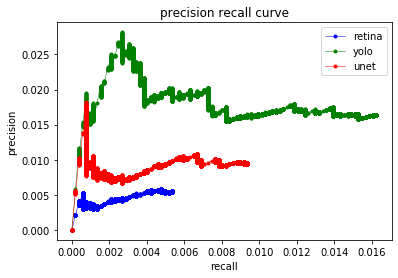

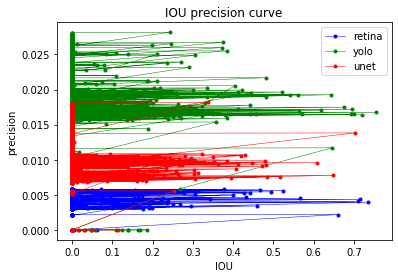

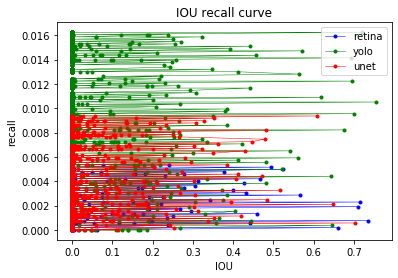

In [129]:
eval_dict = eval_metrics(unet_df, yolo_df, retina_df, mrcnn_df, unet_iou_list, yolo_iou_list, retina_iou_list, mrcnn_iou_list)